1/1 [==============================] - 1s 1s/step

Internal contour area: 4538368.0 pixels
External contour area: 11962880.0 pixels
Ratio: 0.38
IoU: 0.81
Major axis (b): 2252.5 pixels
Minor axis (a): 2164.5 pixels
Radius (D): 4016.2 pixels
Farthest distance (h): 1082.42 pixels


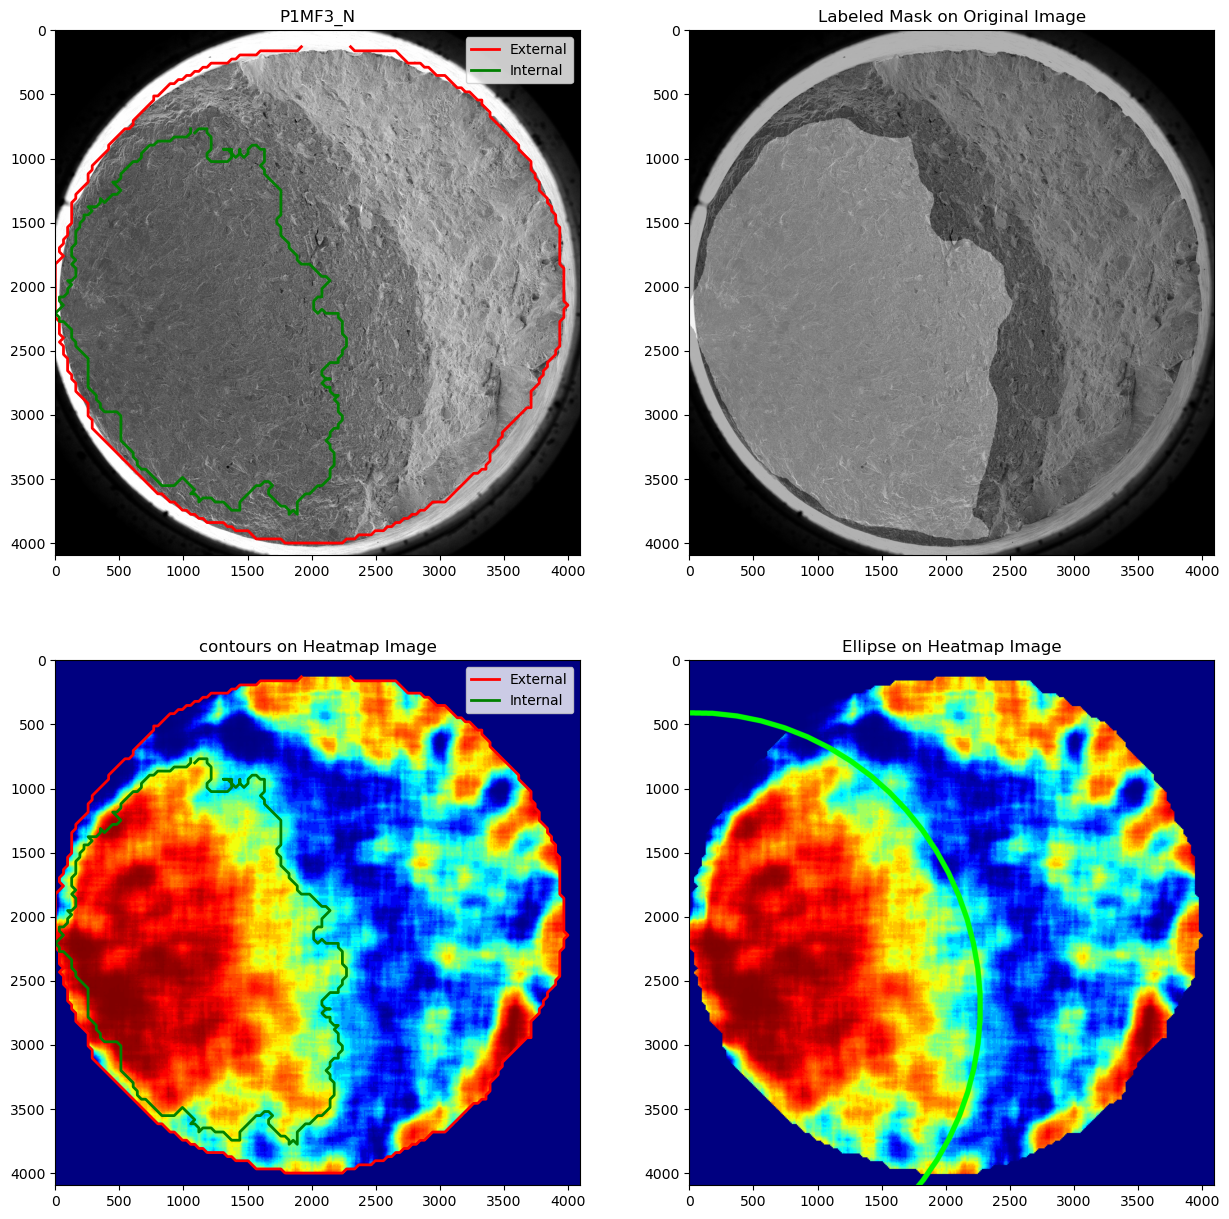

In [30]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
from shapely.geometry import Polygon

# Paths
image_path = 'D:\\Titanium_pictures\\P1MF3_N_01.tif'
ext_model_path = 'D:\\unet_model\\unet_model'
int_model_path = 'D:\\internal_smaller_mask_unet_model\\internal_smaller_mask_unet_model'
labeled_mask_path = 'D:\\internal_smaller_mask\\internal_smaller_mask\\train\\P1MF3_N.png'

# Load the models
ex_cnt_model = tf.keras.models.load_model(ext_model_path)
in_cnt_model = tf.keras.models.load_model(int_model_path)

# Convert the image from format tif to png
im = Image.open(image_path)
im.save(image_path[:-3] + 'png')
image_path = image_path[:-3] + 'png'

# Read and preprocess the image
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, width = gray.shape
img = img[0:width, 0:width]
cv2.imwrite(image_path, img)

# Define functions
def get_contour(mask: np.ndarray):
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    erosion = cv2.erode(thresh, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

def crop_image(img, contour):
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    img = cv2.bitwise_and(img, mask)
    return img

def read_image(file_path):
    return cv2.imread(file_path)

def find_center_of_mass(contour):
    hull = cv2.convexHull(contour)
    ellipse = cv2.fitEllipse(hull)
    (x, y), (MA, ma), angle = ellipse
    return (int(x), int(y))

def find_center_of_mass2(contour):
    M = cv2.minEnclosingCircle(contour)
    return (int(M[0][0]), int(M[0][1]))

def calculate_vector(center1, center2):
    return (center2[0] - center1[0], center2[1] - center1[1])

def is_point_near_line(point, line_start, line_end, eps1):
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    line_vec = line_end - line_start
    point_vec = point - line_start
    cross_prod = np.cross(line_vec, point_vec)
    norm_line_vec = np.linalg.norm(line_vec)
    distance = np.linalg.norm(cross_prod) / norm_line_vec
    return abs(distance) <= eps1

def find_points_near_line(points, line_start, line_end, eps1):
    step = 0.1
    max_eps = 100
    points_near_line = []
    current_eps = eps1

    while len(points_near_line) < 1000 and current_eps <= max_eps:
        for point in points:
            if is_point_near_line(point, line_start, line_end, current_eps):
                points_near_line.append(point)
        current_eps += step

    return np.array(points_near_line)

def is_point_on_left_or_right_side(point, line_start, line_end):
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    original_line_vector = line_end - line_start
    orthogonal_line_vector = np.array([-original_line_vector[1], original_line_vector[0]])
    new_line_end = line_start + orthogonal_line_vector
    point_vector = point - line_start
    new_line_vector = new_line_end - line_start
    cross_prod = np.cross(new_line_vector, point_vector)
    return 'left' if cross_prod > 0 else 'right'

def find_farthest_point(contour, center, axis_angle):
    farthest_distance = 0
    for point in contour:
        vector = np.array(point[0]) - np.array(center)
        axis_vector = np.array([np.cos(np.radians(axis_angle)), np.sin(np.radians(axis_angle))])
        distance = np.dot(vector, axis_vector)
        farthest_distance = max(farthest_distance, abs(distance))
    return farthest_distance

def adjust_ellipse(contour, new_center, vector, step_size=1, max_iterations=1000):
    new_center = new_center[0]
    ellipse = cv2.fitEllipse(contour)
    (x, y), (MA, ma), angle = ellipse
    angle = np.degrees(np.arctan2(vector[1], vector[0]))
    farthest_distance = find_farthest_point(contour, new_center, angle)
    new_major_axis = ma * (ma / MA)
    new_minor_axis = farthest_distance * 2
    ellipse = (new_center, (new_minor_axis, new_major_axis), angle)
    return ellipse, farthest_distance

def find_ellipse(in_cnt, ex_cnt):
    ex_cnt_center = find_center_of_mass2(ex_cnt)
    in_cnt_center = find_center_of_mass(in_cnt)
    vector = calculate_vector(ex_cnt_center, in_cnt_center)
    eps1 = 0.1
    points_near_line = find_points_near_line(ex_cnt, ex_cnt_center, in_cnt_center, eps1)
    left_points = []
    right_points = []
    for point in points_near_line:
        if is_point_on_left_or_right_side(point, ex_cnt_center, in_cnt_center) == 'left':
            left_points.append(point)
        else:
            right_points.append(point)

    side = is_point_on_left_or_right_side(in_cnt_center, ex_cnt_center, in_cnt_center)
    points = np.array(left_points) if side == 'left' else np.array(right_points)
    sample_point = points[0]
    ellipse, farthest_distance = adjust_ellipse(in_cnt, sample_point, vector)
    return ellipse, farthest_distance

# Load the original image
original_img = cv2.imread(image_path)

# Predict the external mask
ext_mask = predict_mask(original_img, ex_cnt_model)

# Crop the image using the external mask
ext_contour = get_contour(ext_mask)
ext_contour = ext_contour * (original_img.shape[0] / 128)
ext_contour = ext_contour.astype(np.int32)
cropped_img = crop_image(original_img, ext_contour)

# Predict the internal mask
heatmap_img = get_heatmap(original_img, ext_contour)
int_mask = predict_mask(heatmap_img, in_cnt_model)

# Find the internal contour
int_contour = get_contour(int_mask)
int_contour = int_contour * (original_img.shape[0] / 128)
int_contour = int_contour.astype(np.int32)

# Load the labeled mask
labeled_mask = cv2.imread(labeled_mask_path, cv2.IMREAD_GRAYSCALE)

# Resize the labeled mask to match the predicted mask dimensions
labeled_mask_resized = cv2.resize(labeled_mask, (128, 128), interpolation=cv2.INTER_NEAREST)

# Check if the masks are loaded correctly
if int_mask is None:
    raise ValueError("Predicted internal mask is None. Please check the model and input image.")
if labeled_mask_resized is None:
    raise ValueError("Labeled mask is None. Please check the path and filename of the labeled mask.")

# Calculate IoU
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

iou = calculate_iou(int_mask, labeled_mask_resized)

# Find ellipse and farthest distance
ellipse, farthest_distance = find_ellipse(int_contour, ext_contour)
ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
ellipse_img = heatmap_img.copy()
cv2.ellipse(ellipse_img, ellipse, (0, 255, 0), 40)  # Increased thickness to 5
radius = cv2.minEnclosingCircle(ext_contour)[1]

# Add additional text
text1 = '\nInternal contour area: ' + str(round(cv2.contourArea(int_contour), 2)) + ' pixels'
text1 += '\nExternal contour area: ' + str(round(cv2.contourArea(ext_contour), 2)) + ' pixels'
text1 += '\nRatio: ' + str(round(cv2.contourArea(int_contour) / cv2.contourArea(ext_contour), 2))
text1 += '\nIoU: ' + str(round(iou, 2)) + '\n'
text1 += 'Major axis (b): ' + str(round(ellipse[1][1] / 2, 2)) + ' pixels'
text1 += '\nMinor axis (a): ' + str(round(ellipse[1][0] / 2, 2)) + ' pixels'
text1 += '\nRadius (D): ' + str(round(radius * 2, 2)) + ' pixels'
text1 += '\nFarthest distance (h): ' + str(round(farthest_distance / 2.0, 2)) + ' pixels'

print(text1)

# Plot the internal and external contours and labeled mask overlay
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
ax[0, 0].imshow(original_img_rgb)
ax[0, 0].plot(ext_contour[:, 0, 0], ext_contour[:, 0, 1], linewidth=2, color='red', label='External')
ax[0, 0].plot(int_contour[:, 0, 0], int_contour[:, 0, 1], linewidth=2, color='green', label='Internal')
ax[0, 0].legend()
ax[0, 0].set_title('P1MF3_N')

# Overlay the labeled mask on the original image
labeled_mask_overlay = cv2.addWeighted(original_img_rgb, 0.7, cv2.cvtColor(labeled_mask, cv2.COLOR_GRAY2RGB), 0.3, 0)
ax[0, 1].imshow(labeled_mask_overlay)
ax[0, 1].set_title('Labeled Mask on Original Image')

heatmap_img_rgb = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)
ax[1, 0].imshow(heatmap_img_rgb)
ax[1, 0].plot(ext_contour[:, 0, 0], ext_contour[:, 0, 1], linewidth=2, color='red', label='External')
ax[1, 0].plot(int_contour[:, 0, 0], int_contour[:, 0, 1], linewidth=2, color='green', label='Internal')
ax[1, 0].legend()
ax[1, 0].set_title('contours on Heatmap Image')

# Plot the ellipse
ax[1, 1].imshow(cv2.cvtColor(ellipse_img, cv2.COLOR_BGR2RGB))
ax[1, 1].set_title('Ellipse on Heatmap Image')

plt.show()
